### QC+ for Cai 2020 dataset

#### Objective: Run advanced QC for the Cai 2020 dataset, including data normalization, log transformation, and UMAP visualization


**Developed by**: Mairi McClean

**Affiliation**: Institute of Computational Biology - Computational Health Centre - Helmholtz Munich

**v221130**


### Load modules

In [48]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
import igraph as ig
from matplotlib import colors
from matplotlib import rcParams

#### Log file and figure output settings

In [49]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
google              NA
h5py                3.6.0
hypergeom_ufunc     NA
igraph              0.10.2
ipykernel           6.16.2
ipywidgets          8.0.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.0
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.6.1
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas      

### Read in anndata object

In [50]:
adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qcd_objects/2111_2511_exported_objects/23/CaiY2022_TB_QCed_pre-process_mm221123.h5ad')
adata

AnnData object with n_obs × n_vars = 66560 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors', 'tissue_colors'
    layers: 'counts', 'sqrt_norm'

### Data normalization

target_sum taken from Scanpy tutorial [https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html]

If exclude_highly_expressed=True, very highly expressed genes are excluded from the computation of the normalization factor (size factor) for each cell. 
> This is meaningful as these can strongly influence the resulting normalized values for all other genes [Weinreb17]."

1e4 changed to 1e6; option to exclude highly expressed genes, set as true - CHANGE THIS FIRST


In [51]:
sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)


### Data log transformation

In [52]:
sc.pp.log1p(adata)

### Identify highly variable genes

Code from Carlos' notebook scVI_exploratory_analysis; Seurat should be used for all generative models
Number of genes (top_genes) based on how mixed the sample is, and computational power. Highest gene number is 10,000
Batch_key is related to the data that we want to perform the filtering on
Carlos runs between 4000 (low RAM) and 7000
subset = True will remove all non-variable genes

In [72]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 5000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [73]:
adata.var.head()


gene_id     mt   ribo  n_cells_by_counts  \
DDX11L1           ENSG00000223972.5  False  False                  8   
ENSG00000238009   ENSG00000238009.6  False  False                 54   
ENSG00000286448   ENSG00000286448.1  False  False                 12   
ENSG00000230021  ENSG00000230021.10  False  False              14932   
ENSG00000278791   ENSG00000278791.1  False  False               6530   

                 mean_counts  pct_dropout_by_counts  total_counts  \
DDX11L1             0.000135              99.987981           9.0   
ENSG00000238009     0.000826              99.918870          55.0   
ENSG00000286448     0.000180              99.981971          12.0   
ENSG00000230021     0.282091              77.566106       18776.0   
ENSG00000278791     0.110081              90.189303        7327.0   

                 highly_variable  highly_variable_rank     means  variances  \
DDX11L1                     True                2947.0  0.000954   0.007616   
ENSG00000238009             True                1922.0  0.006275   0.048687   
ENSG00000286448             True                2442.0  0.001417   0.011175   
ENSG00000230021             True                 389.0  1.771820  10.924513   
ENSG00000278791             True                1919.0  0.766505   5.430839   

                 variances_norm  highly_variable_nbatches  
DDX11L1                0.455338                        11  
ENSG00000238009        0.904185                        11  
ENSG00000286448        0.546799                        11  
ENSG00000230021        1.057407                        11  
ENSG00000278791        1.000032                        11

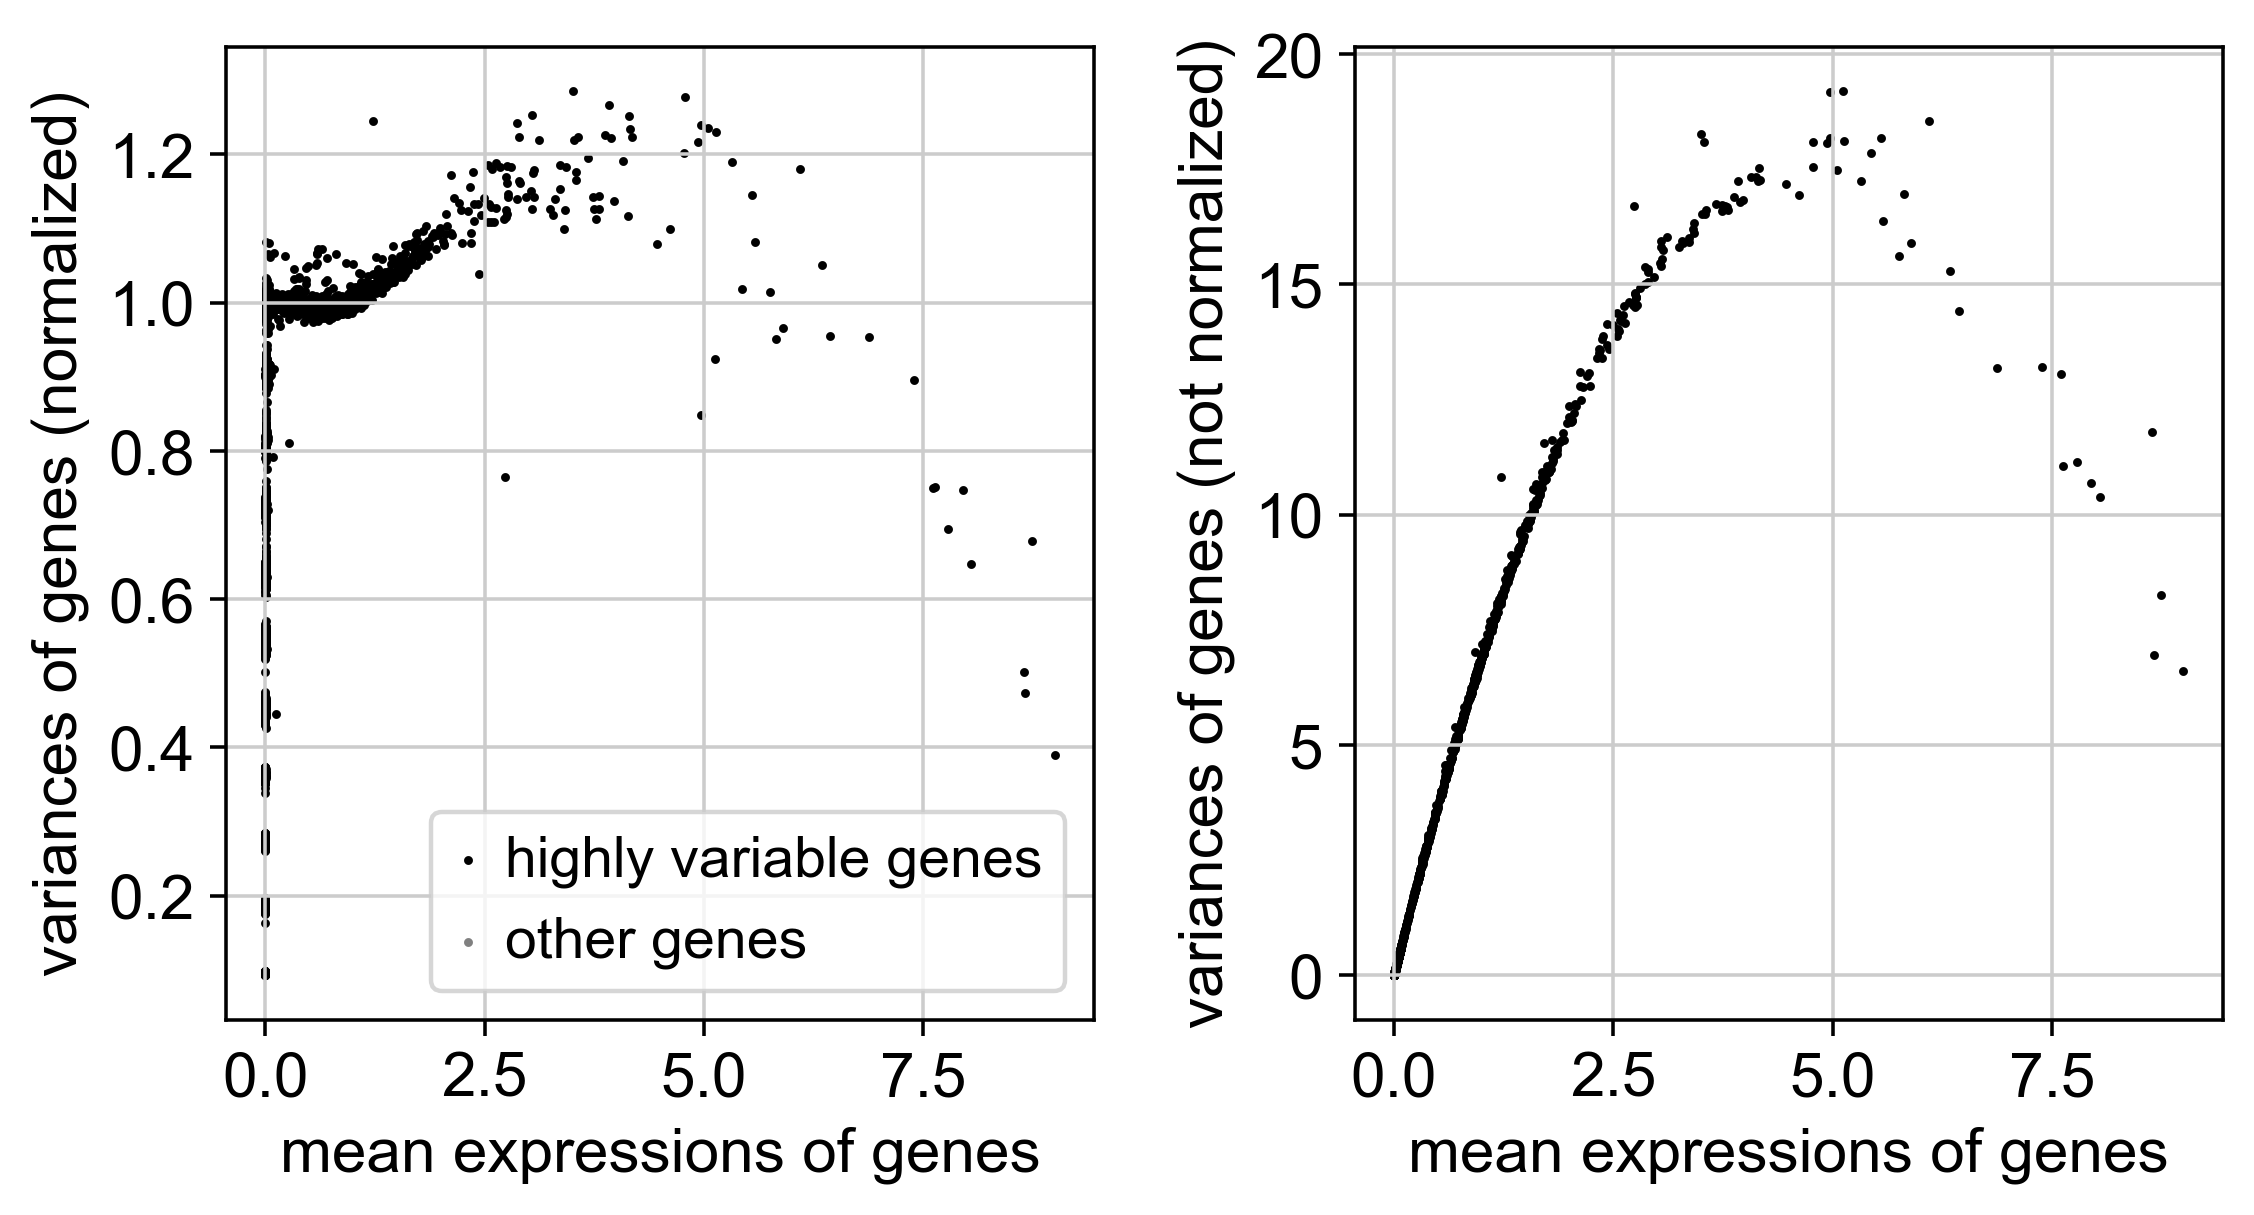

In [74]:
sc.pl.highly_variable_genes(adata)


We want to see between 0.25 and 0.75
This particular pattern either means that the data is garbage or that it is highly significant, caused by disease
Could see if changing the number of genes from between 4000 to 7000

### PCA

In [56]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


In [57]:
adata

AnnData object with n_obs × n_vars = 66560 × 4000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'donor_colors', 'sample_colors', 'tissue_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'sqrt_norm'

Can add covariates here below; can remove frames from image

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


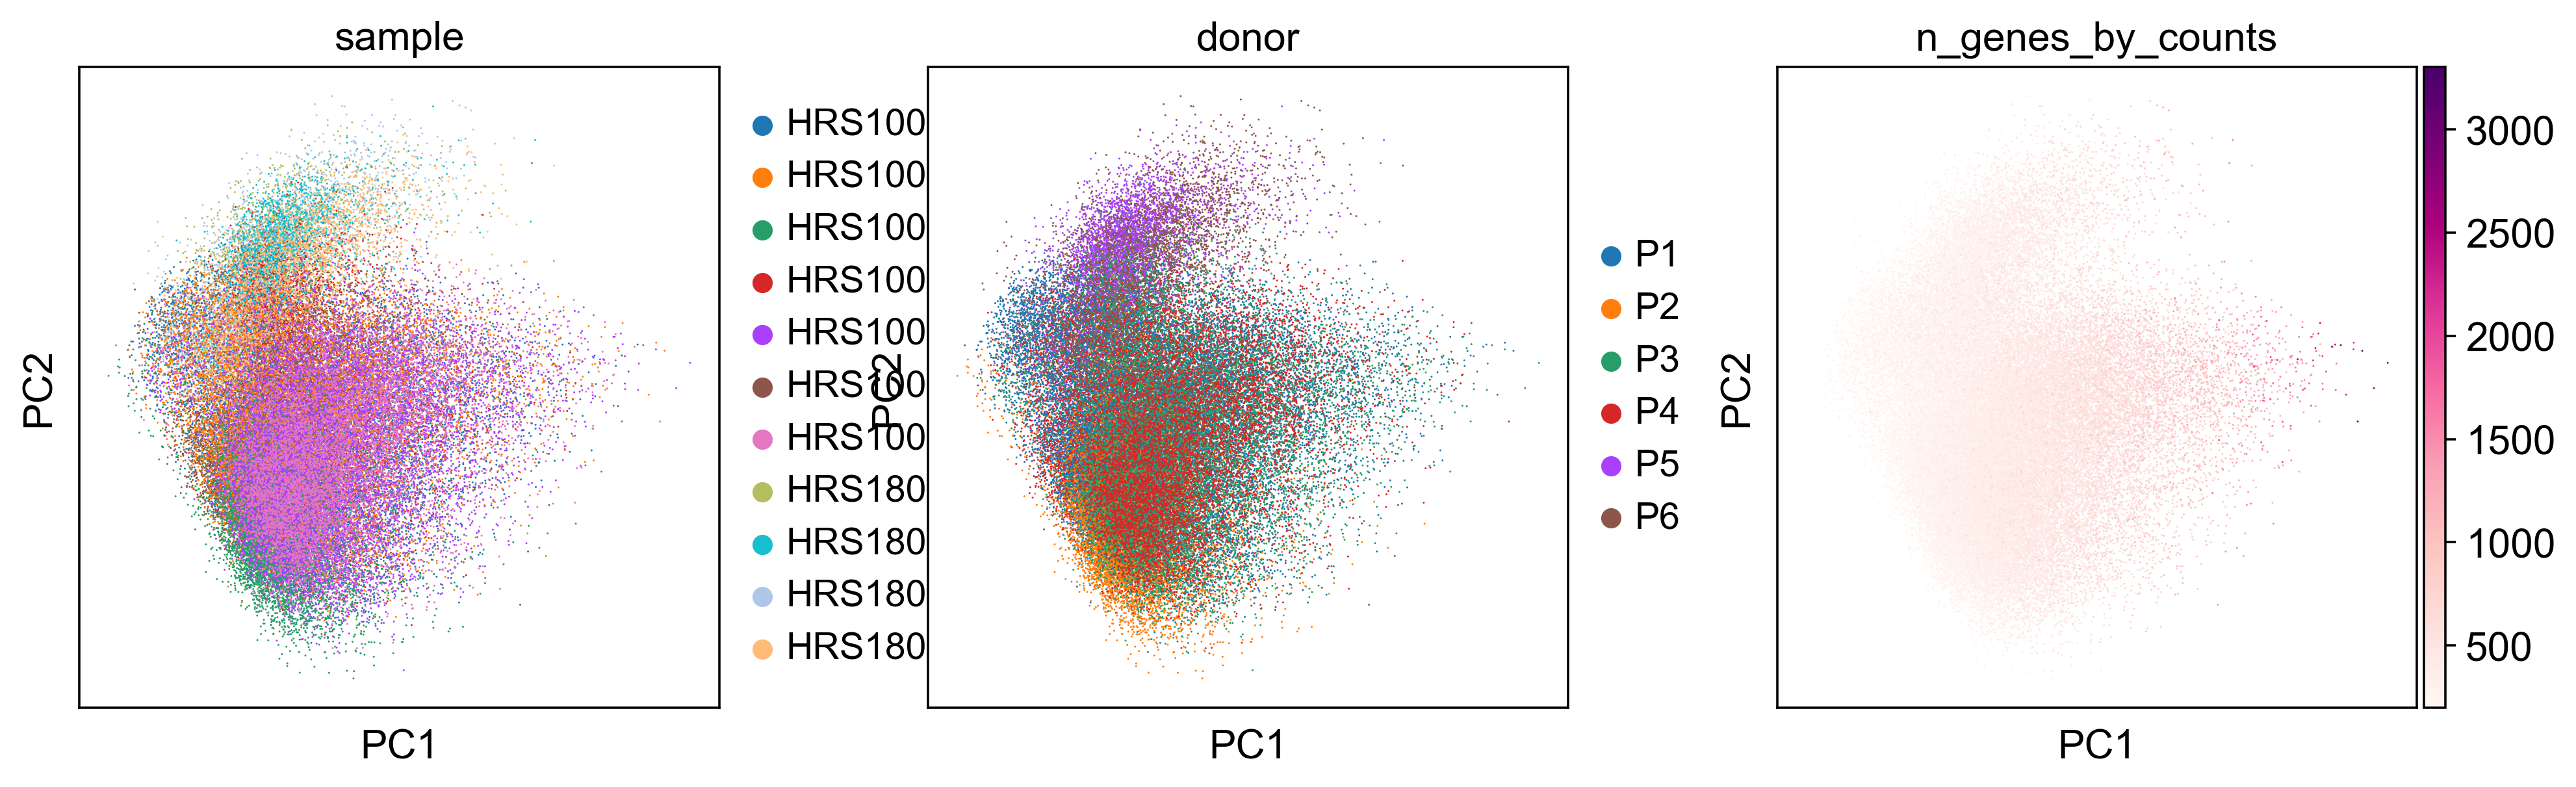

In [58]:
sc.pl.pca(adata, color = ['sample', 'donor', 'n_genes_by_counts'])

### Computing neighbourhood graph

Carlos chooses 50 neighbours, and 50 PCs (PCs used to be taken from elbow graph)

This step is done to create a 'scaffold' of the data; UMAP embedding will then place data over scaffold to see how it fits

In [59]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)



computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)


### UMAP embedding

#### Clustering

In [60]:
# added to avoid error arising from running subsequent cell on its own

sc.tl.leiden(adata)

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:33)


In [61]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:39)


In [63]:
adata.var.head()


gene_id     mt   ribo  n_cells_by_counts  \
DDX11L1           ENSG00000223972.5  False  False                  8   
ENSG00000238009   ENSG00000238009.6  False  False                 54   
ENSG00000286448   ENSG00000286448.1  False  False                 12   
ENSG00000230021  ENSG00000230021.10  False  False              14932   
ENSG00000278791   ENSG00000278791.1  False  False               6530   

                 mean_counts  pct_dropout_by_counts  total_counts  \
DDX11L1             0.000135              99.987981           9.0   
ENSG00000238009     0.000826              99.918870          55.0   
ENSG00000286448     0.000180              99.981971          12.0   
ENSG00000230021     0.282091              77.566106       18776.0   
ENSG00000278791     0.110081              90.189303        7327.0   

                 highly_variable  highly_variable_rank     means  variances  \
DDX11L1                     True                 601.5  0.000954   0.007616   
ENSG00000238009             True                1063.0  0.006275   0.048687   
ENSG00000286448             True                 832.0  0.001417   0.011175   
ENSG00000230021             True                 141.0  1.771820  10.924513   
ENSG00000278791             True                 663.0  0.766505   5.430839   

                 variances_norm  highly_variable_nbatches  
DDX11L1                0.461496                         2  
ENSG00000238009        0.909985                         1  
ENSG00000286448        0.557035                         2  
ENSG00000230021        1.153774                         7  
ENSG00000278791        1.048885                         5

In [64]:
adata.obs.head()

study individual     sample  \
barcode                                                                     
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq  CaiY_2022  HRI111687  HRS180101   

                                         tissue donor data_type  \
barcode                                                           
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq   PBMC    P5  scRNAseq   

                                                       centre version  \
barcode                                                                 
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq  Shenzhen University   10XV2   

                                             object       protocol  ...  \
barcode                                                             ...   
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq  ...   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq  ...   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq  ...   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq  ...   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq  HRS180101  pbmc_scRNAseq  ...   

                                          total_counts_ribo  pct_counts_ribo  \
barcode                                                                        
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq                6.0         1.492537   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq               19.0         4.513064   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq                3.0         0.961538   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq               11.0         2.558140   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq               17.0         3.663793   

                                          percent_mt2  n_counts  percent_chrY  \
barcode                                                                         
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq     0.049751     402.0      0.248756   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq     0.125891     421.0      0.000000   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq     0.089744     312.0      0.000000   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq     0.076744     430.0      0.000000   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq     0.112069     464.0      0.000000   

                                          XIST-counts   S_score  G2M_score  \
barcode                                                                      
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq          0.0 -0.132946  -0.055294   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq          0.0  0.130685  -0.037332   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseq          0.0 -0.188707   0.000000   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseq          0.0 -0.085630  -0.070359   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseq          0.0 -0.064381   0.263002   

                                          predicted_doublets  leiden  
barcode                                                               
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseq                 0.0       8  
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseq                 0.0       4  
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAs

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


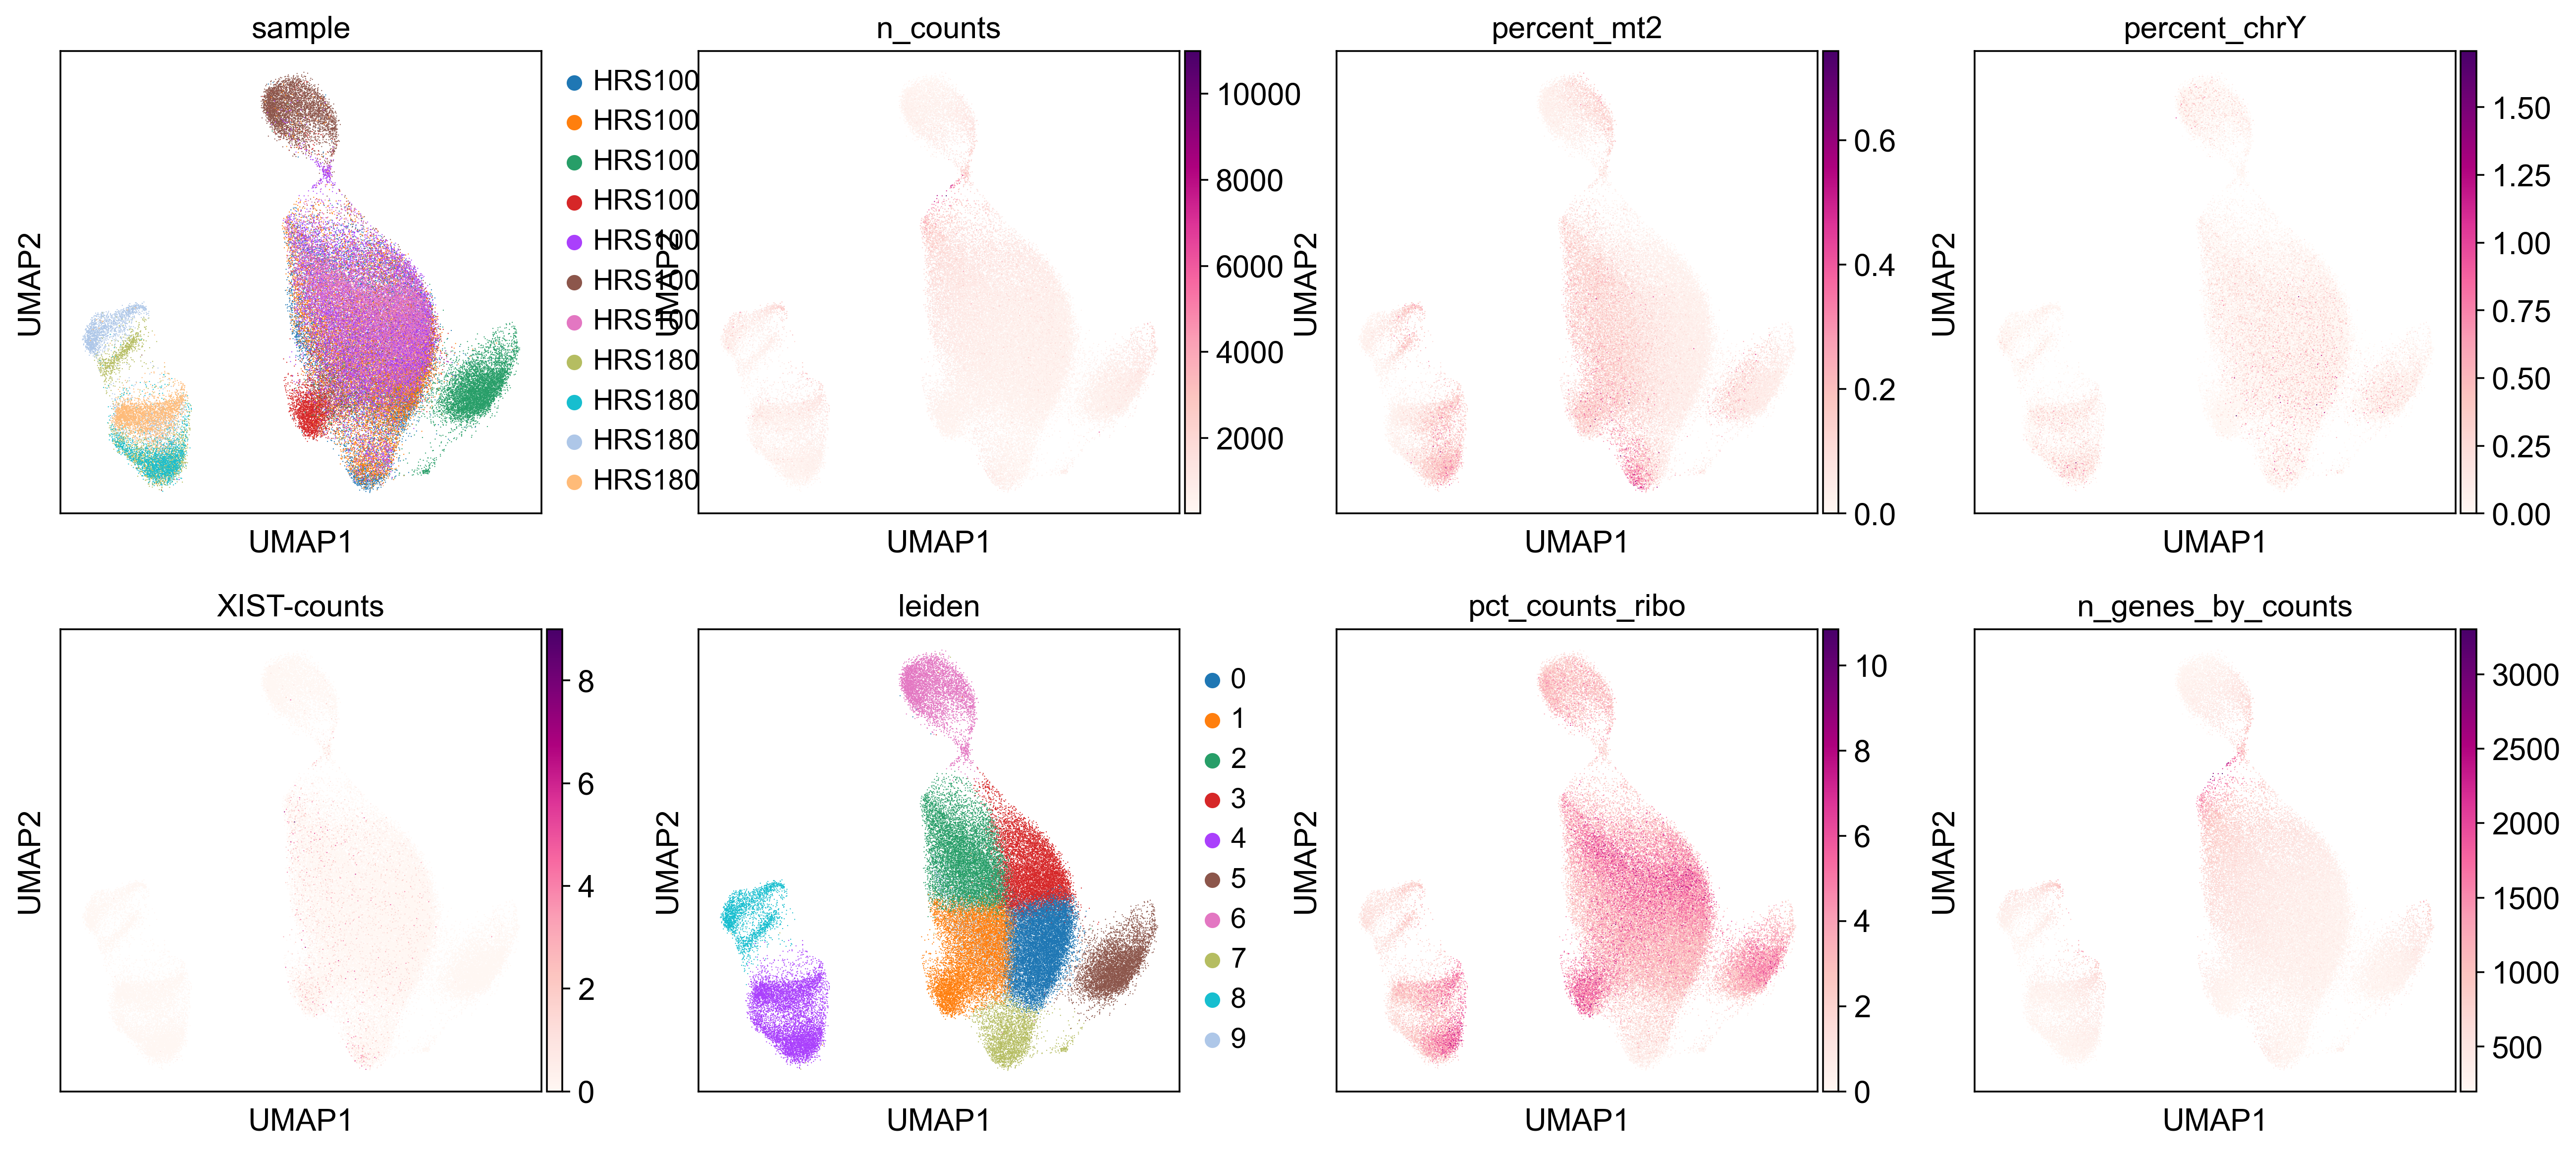

In [71]:
sc.pl.umap(adata, color=['sample',
    'n_counts', 
    'percent_mt2',  
    'percent_chrY', 
    'XIST-counts',  
    'leiden',   
    'pct_counts_ribo', 'n_genes_by_counts'], size = 1)

In [66]:
# Each sample has made it's own cluster, which is batch effect
# choose variety of covariates from obs for panel

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


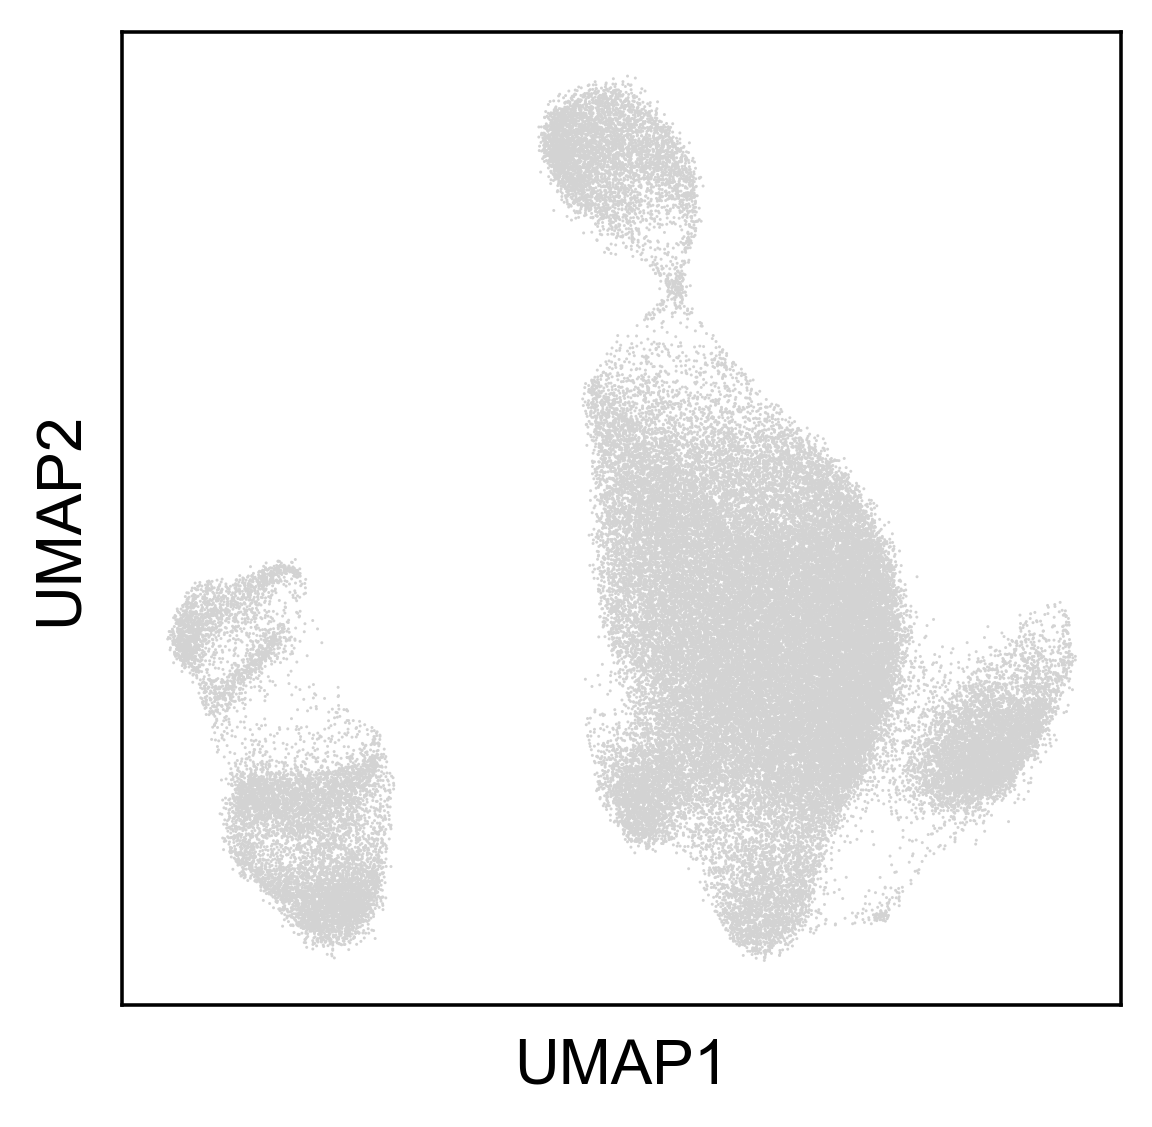

In [67]:
# Now we can use the following code to plot the scaled and corrected gene expression data

sc.pl.umap(adata, use_raw=False, )

### Writing out object


In [68]:
adata.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qc_plus_visualisation/221201_CaiY2022_MM_UMAP.h5ad')
# needs extension .h5ad